# Tutor Feedback
Very nice in-depth analysis and generally well-structured notebook. Just keep it up.

Ex1: 1/1
Ex2: 1/1
Ex3: 1/1

Ex 1:
- For GPU -> Use Google Colab
- Autoencoder: squeeze information through bottleneck, only the most relevant features will remain
- Upward convolution (or TransposeConvolution): see notes
- last layer: pixel-wise softmax
- weight-initialisation: see paper
- dropout layers as regularisation
- treatment of hitting image boundaries with filter: mirror image at boundary

Ex 2:
 - general: W, W' widths; F: filter size; S: stride length; P: padding (symm.)
 - W' = L* floor(W-F +2P) / S + 1)
 - for AlexNet: (224x224x3) w/ F=11 and S=4 -->(55x55x43)
 - without padding: W' = 54 -> agrees with Keras
 - with padding: W' = 55 -> expected from paper, disagrees with Keras
 - in Keras: W' = 56 (padding = 'same')
 - for S=1: W=W' works
 - for S!=1: W' = ceil(W/S) = 56 ('same'); W' = ceil( (W-F+1)/S ) = 54 ('valid')
 
 Local Response Normalization (LRN)
 -> see notes

In [2]:
import numpy as np
import matplotlib.pylab as plt
import numpy.random as rd

from sklearn.datasets import fetch_openml # MNIST data
from sklearn.model_selection import train_test_split

#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Cropping2D

Using TensorFlow backend.


In [1]:
!ls

1505.04597.pdf
4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
deep_learning_book.pdf
MarioGaimann_06_corr.ipynb
MarioGaimann_06.ipynb
proof.jpg
uebung06.pdf


## A1 - U-Net

In [53]:
# padding "valid" -> no padding


# INPUT
visible = Input(shape=(572,572,1))


# DOWNCONVOLUTION
conv1 = (Conv2D(filters = 64, input_shape=(572,572,1), kernel_size=3, padding="valid", strides=(1,1)))(inputdata)
conv2 =(Conv2D(filters = 64, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv1)
pool1 = (MaxPooling2D(pool_size=(2,2)))(conv2)

conv3 = (Conv2D(filters = 128, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(pool1)
conv4 = (Conv2D(filters = 128, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv3)
pool2 = (MaxPooling2D(pool_size=(2,2)))(conv4)

conv5 = (Conv2D(filters = 256, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(pool2)
conv6 = (Conv2D(filters = 256, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv5)
pool3 = (MaxPooling2D(pool_size=(2,2)))(conv6)

conv7 = (Conv2D(filters = 512, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(pool3)
conv8 = (Conv2D(filters = 512, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv7)
pool4 = (MaxPooling2D(pool_size=(2,2)))(conv8)

conv9 = (Conv2D(filters = 1024, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(pool4)
conv10 = (Conv2D(filters = 1024, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv9)
                 
    
# UPCONVOLUTION
upsamp1 = (UpSampling2D(size = 2))(conv10)
conv8_cr = (Cropping2D(cropping= (4,4) ))(conv8) # 64-56 = 8, symm. crop by 4 
concat1 = concatenate([conv8_cr, upsamp1])
conv11 = (Conv2D(filters = 512, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(concat1)
conv12 = (Conv2D(filters = 512, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv11)

upsamp2 = (UpSampling2D(size = 2))(conv12)
conv6_cr = (Cropping2D(cropping= (16,16) ))(conv6) # 136-104 = 32, symm. crop by 16 
concat2 = concatenate([conv6_cr, upsamp2])
conv13 = (Conv2D(filters = 256, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(concat2)
conv14 = (Conv2D(filters = 256, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv13)

upsamp3 = (UpSampling2D(size = 2))(conv14)
conv4_cr = (Cropping2D(cropping= (40,40) ))(conv4) # 280-200 = 80, symm. crop by 40 
concat3 = concatenate([conv4_cr, upsamp3])
conv15 = (Conv2D(filters = 128, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(concat3)
conv16 = (Conv2D(filters = 128, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv15)
    
upsamp4 =(UpSampling2D(size = 2))(conv16)
conv2_cr = (Cropping2D(cropping= (88,88) ))(conv2) # 568-392 = 176, symm. crop by 88
concat4 = concatenate([conv2_cr, upsamp4])
conv17 = (Conv2D(filters = 64, kernel_size=3, padding="valid", strides=(1,1)))(concat4)
conv18 = (Conv2D(filters = 64, kernel_size=3, padding="valid", strides=(1,1), activation='relu'))(conv17)

output = (Conv2D(filters = 2, kernel_size=1, padding="valid", strides=(1,1), activation='relu'))(conv18)


# COMPILE
model = Model(inputs=inputdata, outputs = output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 572, 572, 1)  0                                            
__________________________________________________________________________________________________
conv2d_482 (Conv2D)             (None, 570, 570, 64) 640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_483 (Conv2D)             (None, 568, 568, 64) 36928       conv2d_482[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_139 (MaxPooling2D (None, 284, 284, 64) 0           conv2d_483[0][0]                 
__________________________________________________________________________________________________
conv2d_484

## A2 - AlexNet 

In [41]:
model = Sequential()

# l1
model.add(Conv2D(filters = 96, kernel_size=11, input_shape = (227, 227, 3), padding="valid", strides=(4,4), activation='relu', data_format="channels_last"))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "valid"))

# l2
model.add(Conv2D(filters = 256, kernel_size=5, padding="same", strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "valid"))

# l3
model.add(Conv2D(filters = 384, kernel_size=3, padding="same", strides=(1,1), activation='relu'))

# l4
model.add(Conv2D(filters = 384, kernel_size=3, padding="same", strides=(1,1), activation='relu'))

# l5
model.add(Conv2D(filters = 256, kernel_size=3, padding="same", strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = "valid"))

# dense
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dense(4069, activation="relu"))
model.add(Dense(1000, activation="softmax"))

# compile
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 13, 13, 256)       884992    
__________

## A3 - PCA

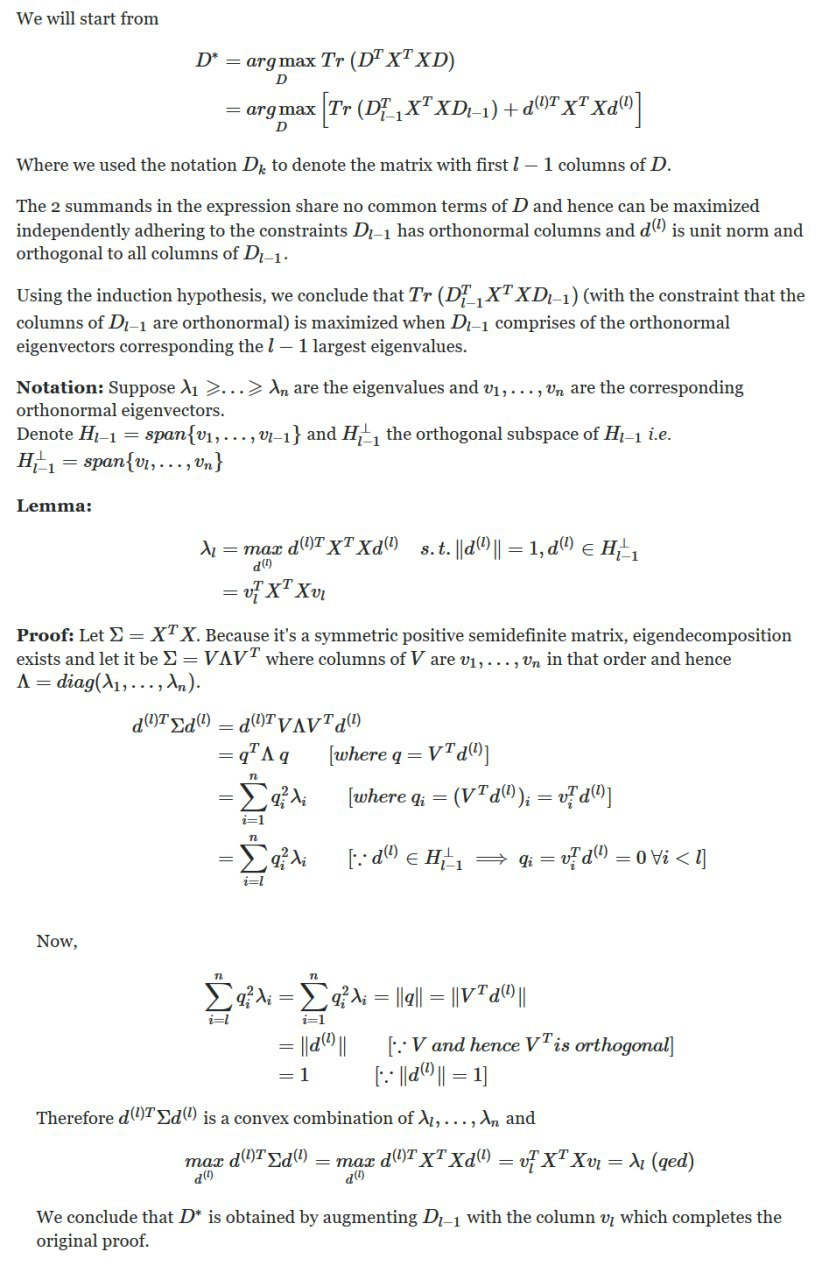

In [43]:
from IPython.display import Image

img = Image(filename=('./proof.jpg'))
img

Explained by 1st component: 97.05 %
Explained by 2nd component: 2.95 %


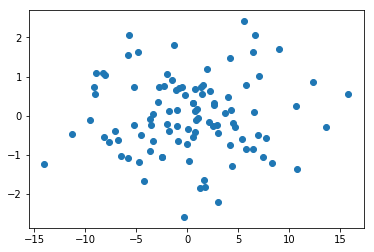

In [21]:
from sklearn.decomposition import PCA 

X = []
for n in range(100):
    x = np.random.normal(loc = 0, scale = 5)
    y = np.random.normal(loc = 0, scale = 1)
    X.append([x,y])
    
plt.scatter([el[0] for el in X], [el[1] for el in X])

pca = PCA(n_components=2)
pca.fit(X)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

print("Explained by 1st component: %g %%" % round(100*pca.explained_variance_ratio_[0],2))  
print("Explained by 2nd component: %g %%" % round(100*pca.explained_variance_ratio_[1],2))  

#print(pca.singular_values_) 

For a difference in variance by a factor of 5 in two dimensions, it can be observed that the first component of a PCA explains about 95% of the overall variance and is therefore the relevant "feature" in this data set.